In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lazypredict.Supervised import LazyClassifier
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import jieba
import re

In [50]:
product = pd.read_csv('ProductRaw.csv')
product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.00,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.50,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.80,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.70,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.80,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [40]:
product.shape

(4404, 10)

In [55]:
review = pd.read_csv('ReviewRaw.csv')
review.head()

,customer_id,product_id,name,full_name,created_time,rating,title,content
0,709310,10001012,Lân Nguyễn Hoàng,Lân Nguyễn Hoàng,NaN,3,Ko dùng đc thẻ nhớ,Lúcđầu quên thông tin nên dùng 512gb thì ko đc...
1,10701688,10001012,Nguyễn Khánh Hòa,Nguyễn Khánh Hòa,NaN,5,Cực kì hài lòng,"Tiki giao hàng nhanh. Sản phẩm đúng như mô tả,..."
2,11763074,10001012,Toàn Phạm Khánh,Toàn Phạm Khánh,2019-04-17 15:42:45,5,Cực kì hài lòng,"chất lượng camera rõ nét, chống mưa nắng tuyệt..."
3,9909549,10001012,Nguyen Quang Minh,NaN,NaN,5,Rất hài lòng,"Hàng được đóng gói cẩn thận, giao hàng nhanh ,..."
4,1827148,10001012,Phạm Bá Đức,Phạm Bá Đức,NaN,5,Cực kì hài lòng,"dễ cài đặt, chất lượng tốt, chế độ xem hồng ng..."


In [56]:
review.shape

(364099, 8)

In [44]:
### Kiểm tra dữ liệu null
print(product.isna().any())
print(review.isna().any())

item_id        False
name           False
description     True
rating         False
price          False
list_price     False
brand          False
group          False
url            False
image          False
dtype: bool
customer_id     False
product_id      False
name             True
full_name        True
created_time     True
rating          False
title            True
content          True
dtype: bool


In [45]:
print(product.isna().sum())
print(review.isna().sum())

item_id        0
name           0
description    3
rating         0
price          0
list_price     0
brand          0
group          0
url            0
image          0
dtype: int64
customer_id          0
product_id           0
name               430
full_name        34628
created_time    246759
rating               0
title               29
content         198305
dtype: int64


In [51]:
### Loại bỏ dữ liệu null product
product = product[~pd.isna(product).any(axis=1)].reset_index(drop=True)
print(product.shape)

(4401, 10)


In [13]:
### Loại bỏ dữ liệu null review
review = review[~pd.isna(review).any(axis=1)].reset_index(drop=True)
print(review.shape)

(36345, 8)


In [14]:
review.head()

,customer_id,product_id,name,full_name,created_time,rating,title,content
0,11763074,10001012,Toàn Phạm Khánh,Toàn Phạm Khánh,2019-04-17 15:42:45,5,Cực kì hài lòng,"chất lượng camera rõ nét, chống mưa nắng tuyệt..."
1,17046856,10001324,Bạch Huy Thắng,Bạch Huy Thắng,2020-04-07 11:38:47,5,Cực kì hài lòng,"Giao hàng nhanh, sản phẩm lắp vào máy nhận chạ..."
2,12533916,10001324,Quoc Nguyen,Quoc Nguyen,2019-06-17 10:14:10,5,Cực kì hài lòng,"good, giao hàng nhanh, đóng gói kỹ hàng hóa đú..."
3,11282171,10001324,Ngô Quang Đạo,Ngô Quang Đạo,2019-03-13 20:07:52,5,Cực kì hài lòng,lắp vào dùng được luôn. ổn định và nhanh hơn hẳn
4,5682927,10001324,Nguyễn Minh Tài,Nguyễn Minh Tài,2017-09-05 02:39:39,4,Hài lòng,ổn áp


### Thống kê cơ bản

In [15]:
product.price.describe()

count       4401.00
mean     2747634.39
std      5529920.68
min         7000.00
25%       150000.00
50%       480888.00
75%      2649000.00
max     62690000.00
Name: price, dtype: float64

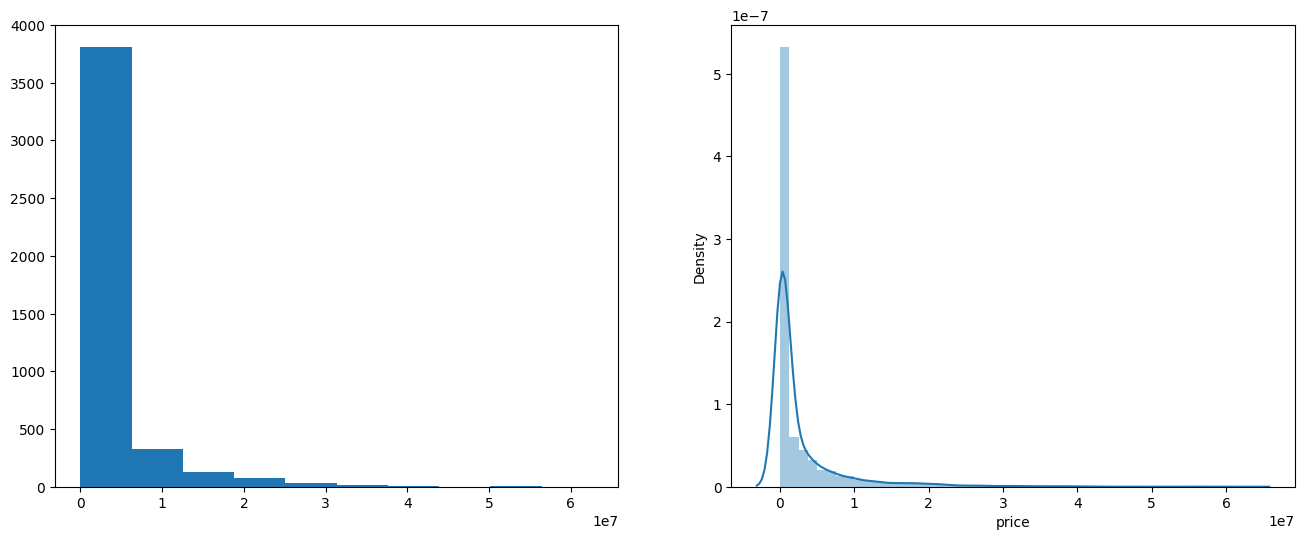

In [16]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.hist(product.price)
plt.subplot(1,2,2)
sns.distplot(product.price)
plt.show()

In [17]:
product.rating.describe()

count   4401.00
mean       3.68
std        1.79
min        0.00
25%        3.80
50%        4.50
75%        4.80
max        5.00
Name: rating, dtype: float64

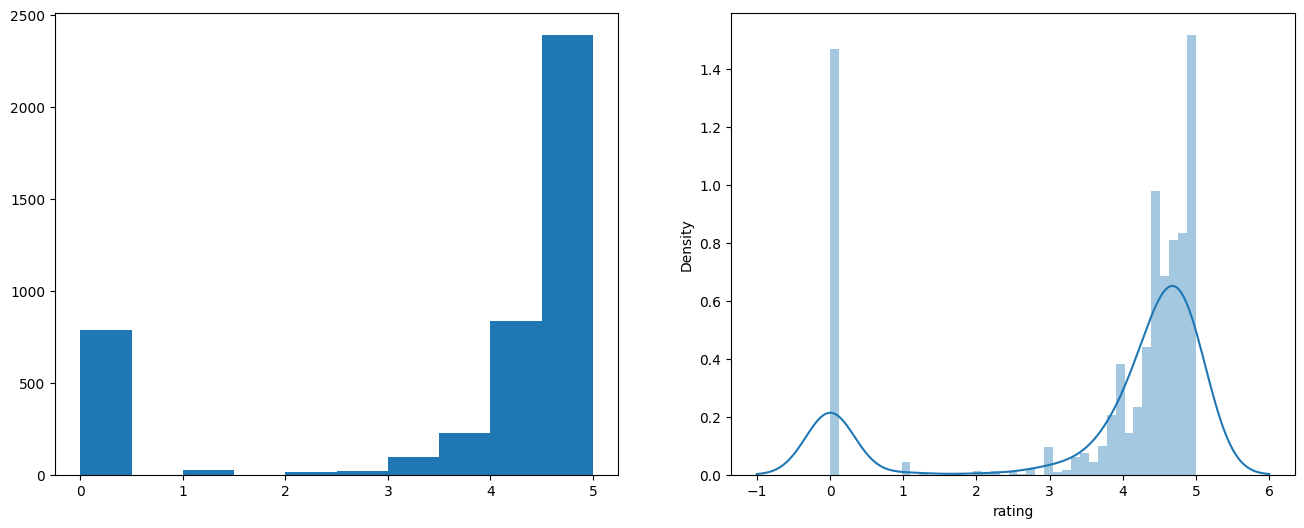

In [18]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.hist(product.rating)
plt.subplot(1,2,2)
sns.distplot(product.rating)
plt.show()

In [19]:
product.corr()

,item_id,rating,price,list_price
item_id,1.00,-0.06,0.13,0.10
rating,-0.06,1.00,-0.11,-0.10
price,0.13,-0.11,1.00,0.96
list_price,0.10,-0.10,0.96,1.00


In [20]:
from pandas_profiling import ProfileReport

In [21]:
profile = ProfileReport(
    product, title="Pandas Profiling Report for Product"
)
profile.to_file("product.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
### Các sản phẩm được đánh giá nhiều nhất
review['product_id'].unique()

array([10001012, 10001324, 10001326, ...,  9977527,  9986769,   998687],
      dtype=int64)

In [23]:
review_top_product = review.groupby('product_id').count().sort_values('rating', ascending = False)[:5]
review_top_product

,customer_id,name,full_name,created_time,rating,title,content
product_id,,,,,,,
58215473,317,317,317,317,317,317,317
48102821,314,314,314,314,314,314,314
299461,238,238,238,238,238,238,238
47321729,225,225,225,225,225,225,225
67910637,225,225,225,225,225,225,225


### Preprocessing

In [31]:
product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.00,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.50,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.80,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.70,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.80,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [53]:
# Loại bỏ các cột không cần thiết
product = product[['item_id', 'name', 'rating', 'price', 'brand', 'group']]

In [26]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [27]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    """document = text.lower()
    document = document.replace("’",'')"""
    document = text.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

# có thể bổ sung thêm các từ: chẳng, chả...
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [28]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R'] 
        # A: Adj, AB: Abverb, V: verb, VB: verb in base form, R: Relative abverb (when, why, where, how; trong tiếng việt là khi nào, tại sao...)
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [34]:
for i in range(review.content.count()):
    review.content[i] = process_text(review.content[i], emoji_dict, teen_dict, wrong_lst)
    review.content[i] = covert_unicode(review.content[i])
    review.content[i] = process_special_word(review.content[i])
    review.content[i] = process_postag_thesea(review.content[i])
    review.content[i] = remove_stopword(review.content[i], stopwords_lst)

In [35]:
review.head()

,customer_id,product_id,name,full_name,created_time,rating,title,content
0,11763074,10001012,Toàn Phạm Khánh,Toàn Phạm Khánh,2019-04-17 15:42:45,5,Cực kì hài lòng,chất_lượng chống disconect
1,17046856,10001324,Bạch Huy Thắng,Bạch Huy Thắng,2020-04-07 11:38:47,5,Cực kì hài lòng,Giao lắp chạy ổn chất_lượng
2,12533916,10001324,Quoc Nguyen,Quoc Nguyen,2019-06-17 10:14:10,5,Cực kì hài lòng,kỹ hàng_hóa bền không_thời trả_lời
3,11282171,10001324,Ngô Quang Đạo,Ngô Quang Đạo,2019-03-13 20:07:52,5,Cực kì hài lòng,lắp
4,5682927,10001324,Nguyễn Minh Tài,Nguyễn Minh Tài,2017-09-05 02:39:39,4,Hài lòng,


## Save file csv 

In [54]:
product.to_csv('product.csv', header=True, index=True)

In [48]:
product.to_excel('product.xlsx', header=True, index=True)

In [57]:
review.to_csv('review.csv', header=True, index=True)